In [102]:
import torch
import parameters_will
import torch.optim as optim
import RNN_Will as _model_
import numpy as np
import matplotlib.pyplot as plt
import pickle
import utils

%load_ext autoreload
%autoreload 2

# Set up our parameters
params = parameters_will.default_params()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Text(0.5, 1.0, 'RNN or Not')

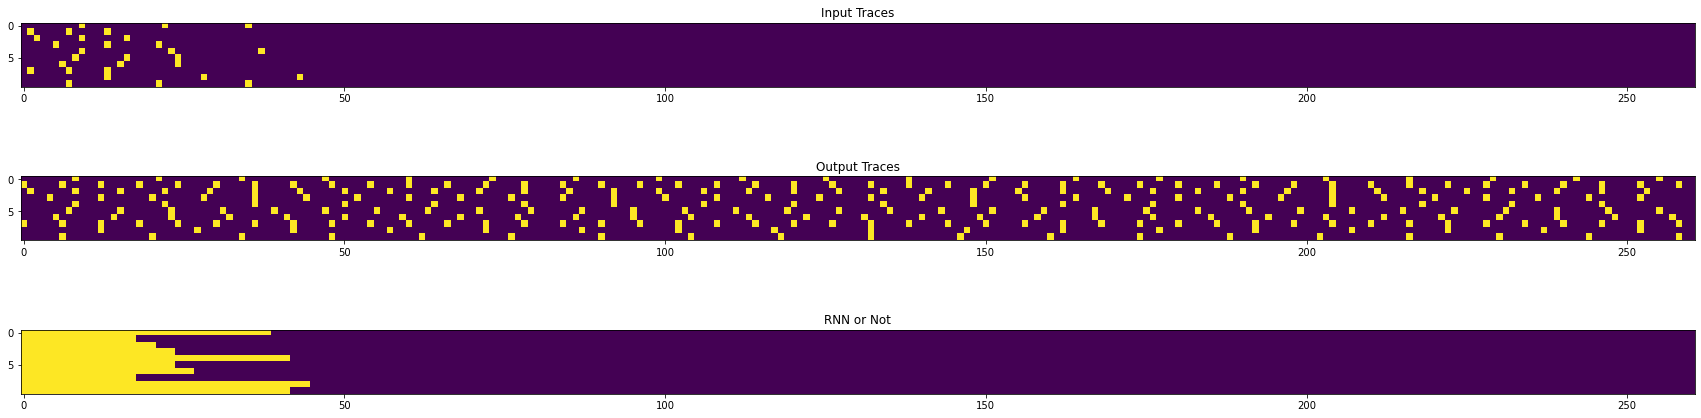

In [110]:
input_dict = utils.generate_data(params)
plt.figure(figsize = (30,8))
plt.subplot(3,1,1)
plt.imshow(input_dict.observation.T)
plt.title('Input Traces')

plt.subplot(3,1,2)
plt.imshow(input_dict.outputs.T)
plt.title('Output Traces')

plt.subplot(3,1,3)
plt.imshow(input_dict.input_or_rnn.T)
plt.title('RNN or Not')

[5, 6, 7, 8, 9, 11, 12, 13, 14, 15]


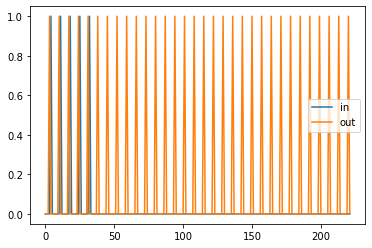

In [27]:
plt.plot(input_dict.observation[:,0],label='in')
plt.plot(input_dict.outputs[:,0],label='out')
plt.legend()

print(params.data.freqs)

In [ ]:
params.train.train_iters = 300000
print_iters = 100
reinitialise = 0

if reinitialise:
    # make instance of model
    model = _model_.VanillaRNN(params.model)
    # put model to gpu (if available)
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Make an ADAM optimizer
    optimizer = optim.Adam(model.parameters(), lr=params.train.learning_rate, weight_decay=params.train.weight_decay)
else:
    model.batch_size = params.data.batch_size

min_loss = np.infty

for train_i in range(params.train.train_iters):

    # 1. Get input data, and convert to tensors (I have assumed you will put inputs etc into a dictionary)
    input_dict = utils.generate_data(params)#, freqs = np.full(params.data.batch_size, 7, dtype=int))
    
    # set all gradients to None
    # optimizer.zero_grad()
    for param in model.parameters():
        param.grad = None
        
    # forward pass
    variables = model(input_dict, device=device)
    
    # collate inputs for model
    (losses, loss_fit) = _model_.compute_losses_torch(input_dict, variables, model, params.train, device=device)

    # backward pass
    losses.backward()

    # clip gradients (you don't have to do this but it's a good idea for RNNs)
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)

    optimizer.step()
    
    if losses.detach() < min_loss:
        min_loss = losses.detach()
        best_model = model
        print(f"{train_i}, new PB! {min_loss}")

    if train_i % print_iters == 0:
        print(f"{train_i}, {losses.item():.5f}, {loss_fit.item():.5f}, {losses.item()-loss_fit.item():.5f}")

0, new PB! 273.6099853515625
0, 273.60999, 246.46169, 27.14830
2, new PB! 250.14892578125
3, new PB! 244.64576721191406
8, new PB! 214.06671142578125
15, new PB! 181.11734008789062
100, 276.60315, 249.69293, 26.91022
133, new PB! 179.2877655029297
155, new PB! 150.53053283691406
200, 223.38428, 192.83517, 30.54910
300, 281.16153, 252.30762, 28.85391
350, new PB! 148.0001983642578
352, new PB! 143.5806121826172
383, new PB! 132.591552734375
388, new PB! 132.3016357421875
400, 210.20639, 187.92282, 22.28357
413, new PB! 119.79489135742188
500, 209.30960, 190.38434, 18.92526
600, 209.95009, 200.04646, 9.90363
700, 228.35986, 211.92908, 16.43079
756, new PB! 90.71827697753906
800, 127.48986, 108.34644, 19.14342
900, 186.66418, 168.83894, 17.82524
1000, 217.55389, 205.64746, 11.90643
1100, 198.75824, 177.75980, 20.99844
1200, 188.00723, 164.77809, 23.22914
1300, 153.30603, 129.13480, 24.17123
1400, 303.29300, 273.20865, 30.08435
1500, 189.12509, 167.71562, 21.40947
1600, 290.15933, 257.6267

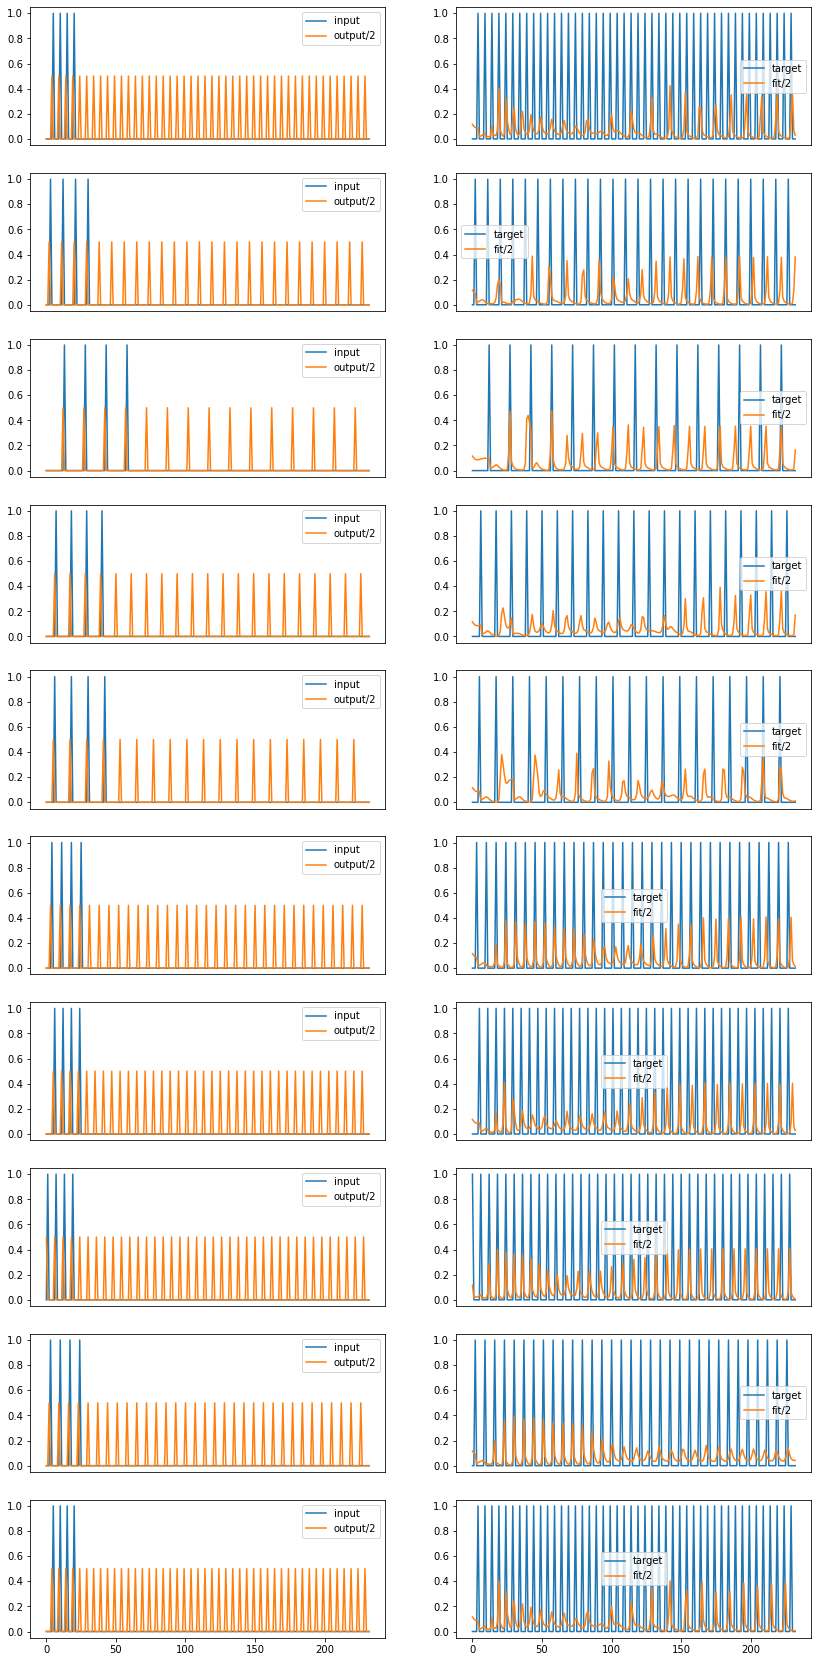

In [109]:
# Let's have a look at how one example is going
use_best = 0
if use_best:
    model_use = best_model
else:
    model_use = model
    
input_dict = utils.generate_data(params)#, freqs = np.full(params.data.batch_size, 7, dtype=int))

variables = model_use(input_dict, device=device)
output = torch.stack(variables.pred)
plt.figure(figsize=(14,3*params.data.batch_size))

for sample in range(params.data.batch_size):
    plt.subplot(params.data.batch_size,2,1+sample*2)
    #plt.title(f'Desired Function, freq = {params.data.freqs[sample]}')
    plt.plot(input_dict.observation[:,sample],label='input')
    plt.plot(0.5*input_dict.outputs[:,sample],label='output/2')
    plt.legend()
    if sample < params.data.batch_size-1:
        plt.xticks([])
        
    plt.subplot(params.data.batch_size,2,2+sample*2)
    #plt.title(f'Network Behaviour, freq = {params.data.freqs[sample]}')
    plt.plot(input_dict.outputs[:,sample], label='target')
    plt.plot(0.5*output.detach().numpy()[:,sample,0], label = 'fit/2')
    plt.legend()
    if sample < params.data.batch_size-1:
        plt.xticks([])